In [1]:
import torch
from torch.utils.data import Dataset
import cv2
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import h5py

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
train_data1 = pd.read_pickle("data/train_data_44525_Ynet.pkl")
train_data2 = pd.read_pickle("data/train_data_44522_Ynet.pkl")
train_data3 = pd.read_pickle("data/train_data_50631_Ynet.pkl")

train_data = pd.concat([train_data1, train_data2, train_data3], ignore_index=True)

del train_data1, train_data2, train_data3

In [27]:
train_df, val_df = train_test_split(train_data, test_size = 0.1)

train_X, train_ref, train_Y = train_df['train_X'], train_df['train_ref'], train_df['train_Y']
val_X, val_ref, val_Y = val_df['train_X'], val_df['train_ref'], val_df['train_Y']

Train set size : 3746 	 Validation set size : 417
(155, 272) (155, 272)


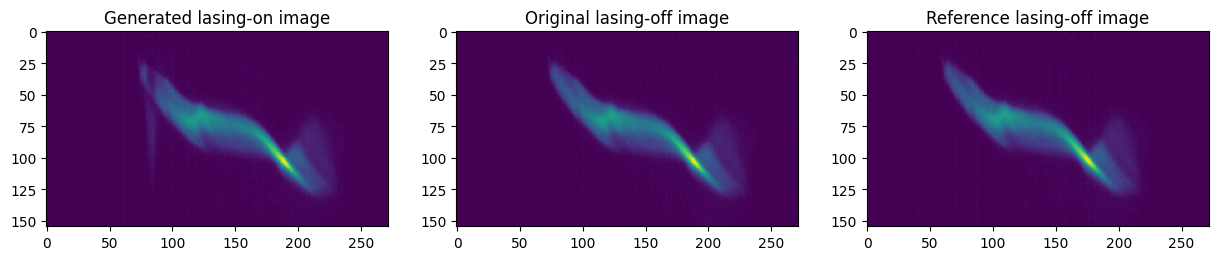

In [29]:
print(f"Train set size : {train_X.shape[-1]} \t Validation set size : {val_X.shape[-1]}")
idx = 3600
fig, ax = plt.subplots(1,3, figsize=(15,8))
ax[0].imshow(train_X[idx])
ax[0].set_title("Generated lasing-on image")
ax[1].imshow(train_Y[idx])
ax[1].set_title("Original lasing-off image")
ax[2].imshow(train_ref[idx])
ax[2].set_title("Reference lasing-off image")

print(train_X[idx].shape, train_Y[idx].shape)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EPOCHS = 30
LR = 1e-4
IMAGE_SIZE_X, IMAGE_SIZE_Y = 140, 200
BATCH_SIZE = 32

In [6]:
import albumentations as alb

def get_augs():
    return alb.Compose([
      alb.Resize(IMAGE_SIZE_X, IMAGE_SIZE_Y)
      ], is_check_shapes=False)

def get_val_augs():
    return alb.Compose([
      alb.Resize(IMAGE_SIZE_X, IMAGE_SIZE_Y),
      ], is_check_shapes=False)

In [7]:
class LasingDataset(Dataset):

    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return(len(self.df))

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image = row.train_X
        ref = row.train_ref
        mask = row.train_Y


        if self.augmentations:
            data = self.augmentations(image = image) 
            image = data['image']
            data = self.augmentations(image = mask)
            mask = data['image']
            data = self.augmentations(image = ref)
            ref = data['image']

        image_on = np.expand_dims(image, axis=0)
        image_off = np.expand_dims(mask, axis=0)
        image_ref = np.expand_dims(ref, axis=0)

        return image_on, image_ref, image_off

In [8]:
trainset = LasingDataset(train_df, get_augs())
valset = LasingDataset(val_df, get_augs())

print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(valset)}")

Size of Trainset : 3746
Size of Validset : 417


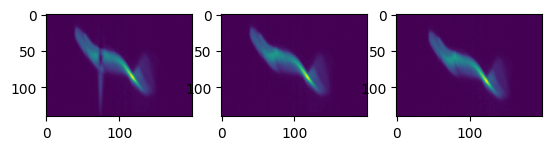

In [9]:
idx = 600
image_on, image_ref, image_off = trainset[idx]
fig, ax = plt.subplots(1,3)
ax[0].imshow(image_on[0])
ax[1].imshow(image_off[0])
ax[2].imshow(image_ref[0])

In [10]:
trainloader = DataLoader(trainset, batch_size= BATCH_SIZE, shuffle = False)
valloader = DataLoader(valset, batch_size= BATCH_SIZE)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [12]:

class YNet(nn.Module):
    def __init__(self):
        super(YNet, self).__init__()
        
        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
               # nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        
        # Encoder for input image
        self.input_conv0 = CBR(1, 32)
        self.input_conv1 = CBR(32, 64)
        self.input_conv2 = CBR(64, 64)
        self.input_pool1 = nn.MaxPool2d(2, 2)
        self.input_conv3 = CBR(64, 128)
        self.input_conv4 = CBR(128, 128)
        self.input_pool2 = nn.MaxPool2d(2, 2)
        self.input_conv5 = CBR(128, 256)
        self.input_conv6 = CBR(256, 256)
        
        # Encoder for reference image
        self.ref_conv0 = CBR(1, 32)
        self.ref_conv1 = CBR(32, 64)
        self.ref_conv2 = CBR(64, 64)
        self.ref_pool1 = nn.MaxPool2d(2, 2)
        self.ref_conv3 = CBR(64, 128)
        self.ref_conv4 = CBR(128, 128)
        self.ref_pool2 = nn.MaxPool2d(2, 2)
        self.ref_conv5 = CBR(128, 256)
        self.ref_conv6 = CBR(256, 256)
        
        # Bottleneck
        #self.bottleneck_conv1 = CBR(256, 256)
        #self.bottleneck_conv2 = CBR(256, 256)
        
        # Decoder
        self.ref_upconv1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.input_upconv1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decoder_conv1 = CBR(384, 128)
        self.decoder_conv2 = CBR(128, 128)
        self.upconv2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decoder_conv3 = CBR(128, 64)
        self.decoder_conv4 = CBR(64, 32)
        self.output_conv = nn.Conv2d(32, 1, 1)
        
    def forward(self, input_img, ref_img):
        # Encode input image
        enc1_input = self.input_conv0(input_img)
        enc2_input = self.input_conv1(enc1_input)
        enc2_input = self.input_conv2(enc2_input)
        enc3_input = self.input_pool1(enc2_input)
        enc3_input = self.input_conv3(enc3_input)
        enc3_input = self.input_conv4(enc3_input)
        enc4_input = self.input_pool2(enc3_input)
        enc5_input = self.input_conv5(enc4_input)
        enc6_input = self.input_conv6(enc5_input)
        
        # Encode reference image
        enc1_ref = self.ref_conv0(ref_img)
        enc2_ref = self.ref_conv1(enc1_ref)
        enc2_ref = self.ref_conv2(enc2_ref)
        enc3_ref = self.ref_pool1(enc2_ref)
        enc3_ref = self.ref_conv3(enc3_ref)
        enc3_ref = self.ref_conv4(enc3_ref)
        enc4_ref = self.ref_pool2(enc3_ref)
        enc5_ref = self.ref_conv5(enc4_ref)
        enc6_ref = self.ref_conv6(enc5_ref)
        
        # Concatenate features at the bottleneck
        #bottleneck_input = torch.cat((enc4_input, enc4_ref), dim=1)
        #bottleneck_output = self.bottleneck_conv1(bottleneck_input)
        #bottleneck_output = self.bottleneck_conv2(bottleneck_output)
        
        # Decoder
        # The features are concatenated at the first layer of the decoder
        dec1_input = self.input_upconv1(enc6_input)
        dec1_ref = self.ref_upconv1(enc6_ref)
        dec1 = torch.cat((dec1_input, dec1_ref, enc3_input), dim=1)
        dec1 = self.decoder_conv1(dec1)
        dec1 = self.decoder_conv2(dec1)
        
        dec2 = self.upconv2(dec1)
        dec2 = torch.cat((dec2, enc2_input), dim=1)
        dec2 = self.decoder_conv3(dec2)
        dec2 = self.decoder_conv4(dec2)
        
        output = self.output_conv(dec2)
        return output

# Instantiate the model
model = YNet()
#print(model)

In [13]:
def train_function(data_loader, model, criterion, optimizer):

    model.train()
    total_loss = 0.0

    for inputs, references, targets in tqdm(data_loader):
        inputs = inputs.to(device)
        references = references.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs, references)

        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)


def eval_function(data_loader, model):

    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for inputs, references, targets in tqdm(data_loader):
            inputs = inputs.to(device)
            references = references.to(device)
            targets = targets.to(device)

            outputs = model(inputs, references)

            loss = criterion(outputs, targets)

            total_loss += loss.item()

    return total_loss / len(data_loader)


In [14]:
#model = UNet()

Train = True

if Train:
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Training loop
    EPOCHS = 100
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_loss = np.Inf

    train_L, val_L = [], []
    for i in range(EPOCHS):

        train_loss = train_function(trainloader, model, criterion, optimizer)
        train_L.append(train_loss)
        val_loss = eval_function(valloader, model)
        val_L.append(val_loss)

        if val_loss < best_val_loss:
            torch.save(model.state_dict(), f'best_model{timestamp}.pt')
            best_val_loss = val_loss

        print(f"Epoch: {i+1}   Train loss: {train_loss}  Val_loss: {val_loss}")
    
    state_dict = torch.load("best_model.pt")
    model.load_state_dict(state_dict)
    model.to(device)
    
    plt.plot(train_L, label="train loss")
    plt.plot(val_L, label="test loss")
    plt.legend()

else:
    
    model = UNet()
    state_dict = torch.load("best_model_yet.pt")
    model.load_state_dict(state_dict)
    model.to(device)
        

100%|██████████| 14/14 [00:01<00:00,  8.18it/s]


Epoch: 1   Train loss: 0.0018628247543948434  Val_loss: 0.001077347289538011


100%|██████████| 14/14 [00:01<00:00,  8.25it/s]


Epoch: 2   Train loss: 0.0009648309363510018  Val_loss: 0.0010299783025402576


100%|██████████| 14/14 [00:01<00:00,  8.27it/s]


Epoch: 3   Train loss: 0.0009378657155370309  Val_loss: 0.0009941310688321079


100%|██████████| 14/14 [00:01<00:00,  8.28it/s]


Epoch: 4   Train loss: 0.0009101874733213494  Val_loss: 0.0009563470645973991


100%|██████████| 14/14 [00:01<00:00,  7.86it/s]


Epoch: 5   Train loss: 0.0008603838613746151  Val_loss: 0.000890431975546692


100%|██████████| 14/14 [00:01<00:00,  7.91it/s]


Epoch: 6   Train loss: 0.0008197713569812951  Val_loss: 0.0008470696650744815


100%|██████████| 14/14 [00:01<00:00,  7.89it/s]


Epoch: 7   Train loss: 0.0007701993700890345  Val_loss: 0.0008106770006374323


100%|██████████| 14/14 [00:01<00:00,  7.85it/s]


Epoch: 8   Train loss: 0.000724561880954336  Val_loss: 0.0007647364067712001


100%|██████████| 14/14 [00:01<00:00,  7.92it/s]


Epoch: 9   Train loss: 0.0006918532922331213  Val_loss: 0.000720758323690721


100%|██████████| 14/14 [00:01<00:00,  7.89it/s]


Epoch: 10   Train loss: 0.0006554703713075053  Val_loss: 0.0006642991606245882


100%|██████████| 14/14 [00:01<00:00,  8.04it/s]


Epoch: 11   Train loss: 0.0006245477613401047  Val_loss: 0.0006425014559811513


100%|██████████| 14/14 [00:01<00:00,  8.08it/s]


Epoch: 12   Train loss: 0.0005947109798938272  Val_loss: 0.000632432008777479


100%|██████████| 14/14 [00:01<00:00,  8.06it/s]


Epoch: 13   Train loss: 0.0005758479357178133  Val_loss: 0.0006173486222646066


100%|██████████| 14/14 [00:01<00:00,  8.06it/s]


Epoch: 14   Train loss: 0.0005545346512778867  Val_loss: 0.0005979986038125519


100%|██████████| 14/14 [00:01<00:00,  8.13it/s]


Epoch: 15   Train loss: 0.0005376071373683447  Val_loss: 0.0005971475392081109


100%|██████████| 14/14 [00:01<00:00,  8.07it/s]


Epoch: 16   Train loss: 0.0005262794756918546  Val_loss: 0.0005786261296764548


100%|██████████| 14/14 [00:01<00:00,  8.23it/s]


Epoch: 17   Train loss: 0.000513289832501175  Val_loss: 0.0005499608586043385


100%|██████████| 14/14 [00:01<00:00,  8.25it/s]


Epoch: 18   Train loss: 0.0004933721499845101  Val_loss: 0.0005346839939842799


100%|██████████| 14/14 [00:01<00:00,  8.12it/s]


Epoch: 19   Train loss: 0.00048235482454864247  Val_loss: 0.0005070332408649847


100%|██████████| 14/14 [00:01<00:00,  8.15it/s]


Epoch: 20   Train loss: 0.0004657093225633015  Val_loss: 0.0004947318770324013


100%|██████████| 14/14 [00:01<00:00,  8.07it/s]


Epoch: 21   Train loss: 0.0004549590271149794  Val_loss: 0.0004919303402337911


100%|██████████| 14/14 [00:01<00:00,  8.14it/s]


Epoch: 22   Train loss: 0.0004427141440396939  Val_loss: 0.0004742295921979738


100%|██████████| 14/14 [00:01<00:00,  8.25it/s]


Epoch: 23   Train loss: 0.0004304873149583542  Val_loss: 0.0004714259723966409


100%|██████████| 14/14 [00:01<00:00,  8.13it/s]


Epoch: 24   Train loss: 0.0004201460189691161  Val_loss: 0.000470867646592004


100%|██████████| 14/14 [00:01<00:00,  8.27it/s]


Epoch: 25   Train loss: 0.00041125053086049727  Val_loss: 0.00046777104060830813


100%|██████████| 14/14 [00:01<00:00,  8.24it/s]


Epoch: 26   Train loss: 0.00040489210615475205  Val_loss: 0.000429954839221734


100%|██████████| 14/14 [00:01<00:00,  8.25it/s]


Epoch: 27   Train loss: 0.00039397568049272366  Val_loss: 0.0004122318870421233


100%|██████████| 14/14 [00:01<00:00,  8.23it/s]


Epoch: 28   Train loss: 0.0003795209566429178  Val_loss: 0.00043162172992846796


100%|██████████| 14/14 [00:01<00:00,  8.02it/s]


Epoch: 29   Train loss: 0.0003786009585413829  Val_loss: 0.0003974601963169074


100%|██████████| 14/14 [00:01<00:00,  8.27it/s]


Epoch: 30   Train loss: 0.00036667265768470717  Val_loss: 0.00041134382731148174


100%|██████████| 14/14 [00:01<00:00,  8.28it/s]


Epoch: 31   Train loss: 0.0003532793406659532  Val_loss: 0.00040352601873954494


100%|██████████| 14/14 [00:01<00:00,  8.20it/s]


Epoch: 32   Train loss: 0.0003438243057659701  Val_loss: 0.0003851428274564179


100%|██████████| 14/14 [00:01<00:00,  8.26it/s]


Epoch: 33   Train loss: 0.0003286055307707086  Val_loss: 0.00035839120807525305


100%|██████████| 14/14 [00:01<00:00,  8.23it/s]


Epoch: 34   Train loss: 0.0003172393046690435  Val_loss: 0.00033176064711629545


100%|██████████| 14/14 [00:01<00:00,  8.27it/s]


Epoch: 35   Train loss: 0.00030743337808062434  Val_loss: 0.00033390354240379693


100%|██████████| 14/14 [00:01<00:00,  8.27it/s]


Epoch: 36   Train loss: 0.0002986363666053167  Val_loss: 0.00032246669953955073


100%|██████████| 14/14 [00:01<00:00,  8.29it/s]


Epoch: 37   Train loss: 0.00029004743518564315  Val_loss: 0.0003238521603634581


100%|██████████| 14/14 [00:01<00:00,  8.27it/s]


Epoch: 38   Train loss: 0.0002885836232562107  Val_loss: 0.0003181422611565462


100%|██████████| 14/14 [00:01<00:00,  8.15it/s]


Epoch: 39   Train loss: 0.00027892623336934406  Val_loss: 0.0003126932237397081


100%|██████████| 14/14 [00:01<00:00,  8.26it/s]


Epoch: 40   Train loss: 0.00026921706690484563  Val_loss: 0.00030975757856919827


100%|██████████| 14/14 [00:01<00:00,  8.29it/s]


Epoch: 41   Train loss: 0.0002646323490021671  Val_loss: 0.0003047827340196818


100%|██████████| 14/14 [00:01<00:00,  8.29it/s]


Epoch: 42   Train loss: 0.00026102212871330143  Val_loss: 0.0002872482135509407


100%|██████████| 14/14 [00:01<00:00,  8.26it/s]


Epoch: 43   Train loss: 0.0002562682202551514  Val_loss: 0.00028607938604961546


100%|██████████| 14/14 [00:01<00:00,  8.29it/s]


Epoch: 44   Train loss: 0.00025171533349548243  Val_loss: 0.0002871376605721058


100%|██████████| 14/14 [00:01<00:00,  8.25it/s]


Epoch: 45   Train loss: 0.000248441960755341  Val_loss: 0.0002763222374986591


100%|██████████| 14/14 [00:01<00:00,  8.30it/s]


Epoch: 46   Train loss: 0.0002437195799464431  Val_loss: 0.0002753134519610155


100%|██████████| 14/14 [00:01<00:00,  8.25it/s]


Epoch: 47   Train loss: 0.0002407812536472131  Val_loss: 0.0002682497922380987


100%|██████████| 14/14 [00:01<00:00,  8.33it/s]


Epoch: 48   Train loss: 0.00023679904305766794  Val_loss: 0.00026466077646806037


100%|██████████| 14/14 [00:01<00:00,  8.34it/s]


Epoch: 49   Train loss: 0.00023387162674857713  Val_loss: 0.00025831898632791957


100%|██████████| 14/14 [00:01<00:00,  8.27it/s]


Epoch: 50   Train loss: 0.00022994721784617484  Val_loss: 0.0002543727231178699


100%|██████████| 14/14 [00:01<00:00,  8.29it/s]


Epoch: 51   Train loss: 0.00022766370880239944  Val_loss: 0.00025427883416081646


100%|██████████| 14/14 [00:01<00:00,  8.26it/s]


Epoch: 52   Train loss: 0.00022507944262450388  Val_loss: 0.00024981113425123373


100%|██████████| 14/14 [00:01<00:00,  8.34it/s]


Epoch: 53   Train loss: 0.00022254780215315788  Val_loss: 0.0002467878647231763


100%|██████████| 14/14 [00:01<00:00,  8.28it/s]


Epoch: 54   Train loss: 0.00022008088619598204  Val_loss: 0.0002471573638363874


100%|██████████| 14/14 [00:01<00:00,  8.30it/s]


Epoch: 55   Train loss: 0.00021699237716394097  Val_loss: 0.00023869456241040358


100%|██████████| 14/14 [00:01<00:00,  8.35it/s]


Epoch: 56   Train loss: 0.00021491437556983713  Val_loss: 0.0002376087785315966


100%|██████████| 14/14 [00:01<00:00,  8.29it/s]


Epoch: 57   Train loss: 0.000212791890065754  Val_loss: 0.00023038006994673715


100%|██████████| 14/14 [00:01<00:00,  8.33it/s]


Epoch: 58   Train loss: 0.0002098161869256173  Val_loss: 0.00021873043650495156


100%|██████████| 14/14 [00:01<00:00,  8.30it/s]


Epoch: 59   Train loss: 0.00020834096339659498  Val_loss: 0.0002173600234008128


100%|██████████| 14/14 [00:01<00:00,  8.31it/s]


Epoch: 60   Train loss: 0.00020575475916256576  Val_loss: 0.00021455473532634123


100%|██████████| 14/14 [00:01<00:00,  8.33it/s]


Epoch: 61   Train loss: 0.00020429997848469164  Val_loss: 0.00021008034361459847


100%|██████████| 14/14 [00:01<00:00,  8.33it/s]


Epoch: 62   Train loss: 0.0002025152072931987  Val_loss: 0.0002085164887830615


100%|██████████| 14/14 [00:01<00:00,  8.31it/s]


Epoch: 63   Train loss: 0.0002017496251136112  Val_loss: 0.00020796265432311754


100%|██████████| 14/14 [00:01<00:00,  8.26it/s]


Epoch: 64   Train loss: 0.00019995297758615088  Val_loss: 0.0002083056845419508


100%|██████████| 14/14 [00:01<00:00,  8.35it/s]


Epoch: 65   Train loss: 0.0001989044395810135  Val_loss: 0.000206495174747293


100%|██████████| 14/14 [00:01<00:00,  8.30it/s]


Epoch: 66   Train loss: 0.00019659817719958343  Val_loss: 0.00020247624343028292


100%|██████████| 14/14 [00:01<00:00,  8.33it/s]


Epoch: 67   Train loss: 0.00019672951162585562  Val_loss: 0.00020696983119705692


100%|██████████| 14/14 [00:01<00:00,  8.27it/s]


Epoch: 68   Train loss: 0.00019512858748153814  Val_loss: 0.00020327766729418987


100%|██████████| 14/14 [00:01<00:00,  8.32it/s]


Epoch: 69   Train loss: 0.00019404010268093987  Val_loss: 0.00020516724284139594


100%|██████████| 14/14 [00:01<00:00,  8.21it/s]


Epoch: 70   Train loss: 0.00019258784626707262  Val_loss: 0.00020018273062305525


100%|██████████| 14/14 [00:01<00:00,  8.34it/s]


Epoch: 71   Train loss: 0.00019163265848982195  Val_loss: 0.00020485217932478657


100%|██████████| 14/14 [00:01<00:00,  8.36it/s]


Epoch: 72   Train loss: 0.00019063139410780238  Val_loss: 0.00020404304398523112


100%|██████████| 14/14 [00:01<00:00,  8.30it/s]


Epoch: 73   Train loss: 0.000189653964838017  Val_loss: 0.00020394655023535182


100%|██████████| 14/14 [00:01<00:00,  8.09it/s]


Epoch: 74   Train loss: 0.00018916450685306483  Val_loss: 0.00020010059857408384


100%|██████████| 14/14 [00:01<00:00,  8.34it/s]


Epoch: 75   Train loss: 0.00018748111275056282  Val_loss: 0.00020264101580583623


100%|██████████| 14/14 [00:01<00:00,  8.37it/s]


Epoch: 76   Train loss: 0.00018627289355825237  Val_loss: 0.00020051528658119163


100%|██████████| 14/14 [00:01<00:00,  8.31it/s]


Epoch: 77   Train loss: 0.00018576685767384026  Val_loss: 0.00019595576824420796


100%|██████████| 14/14 [00:01<00:00,  8.32it/s]


Epoch: 78   Train loss: 0.0001841213045320158  Val_loss: 0.0001913307013247894


100%|██████████| 14/14 [00:01<00:00,  8.32it/s]


Epoch: 79   Train loss: 0.0001835880012565166  Val_loss: 0.000190254289918812


100%|██████████| 14/14 [00:01<00:00,  8.33it/s]


Epoch: 80   Train loss: 0.00018264406229471947  Val_loss: 0.00019353046809555963


100%|██████████| 14/14 [00:01<00:00,  8.25it/s]


Epoch: 81   Train loss: 0.0001819016817874291  Val_loss: 0.00018993148426358988


100%|██████████| 14/14 [00:01<00:00,  8.26it/s]


Epoch: 82   Train loss: 0.00018108901787269071  Val_loss: 0.00018903571981354617


100%|██████████| 14/14 [00:01<00:00,  8.28it/s]


Epoch: 83   Train loss: 0.00018276966967910007  Val_loss: 0.00019084382230565616


100%|██████████| 14/14 [00:01<00:00,  8.24it/s]


Epoch: 84   Train loss: 0.00017920278252735812  Val_loss: 0.0001917236201864268


100%|██████████| 14/14 [00:01<00:00,  8.29it/s]


Epoch: 85   Train loss: 0.00017946903947523748  Val_loss: 0.00019078267048046525


100%|██████████| 14/14 [00:01<00:00,  8.31it/s]


Epoch: 86   Train loss: 0.00017798171239072393  Val_loss: 0.00018782293877198493


100%|██████████| 14/14 [00:01<00:00,  8.27it/s]


Epoch: 87   Train loss: 0.00017710696161977188  Val_loss: 0.0001871177030677375


100%|██████████| 14/14 [00:01<00:00,  8.28it/s]


Epoch: 88   Train loss: 0.00017672213252191828  Val_loss: 0.00018601381400783014


100%|██████████| 14/14 [00:01<00:00,  8.32it/s]


Epoch: 89   Train loss: 0.00017584723894488287  Val_loss: 0.00018490868803512837


100%|██████████| 14/14 [00:01<00:00,  8.27it/s]


Epoch: 90   Train loss: 0.00017495296036694358  Val_loss: 0.0001838760524281367


100%|██████████| 14/14 [00:01<00:00,  8.32it/s]


Epoch: 91   Train loss: 0.00017464278043608845  Val_loss: 0.00018160310459539427


100%|██████████| 14/14 [00:01<00:00,  8.34it/s]


Epoch: 92   Train loss: 0.00017217771990976486  Val_loss: 0.0001821190676959564


100%|██████████| 14/14 [00:01<00:00,  8.32it/s]


Epoch: 93   Train loss: 0.00017327398159916086  Val_loss: 0.00018021854702965356


100%|██████████| 14/14 [00:01<00:00,  8.24it/s]


Epoch: 94   Train loss: 0.00017207267438160191  Val_loss: 0.0001799534958471278


100%|██████████| 14/14 [00:01<00:00,  8.34it/s]


Epoch: 95   Train loss: 0.00017215359511576058  Val_loss: 0.00018128492385065847


100%|██████████| 14/14 [00:01<00:00,  8.30it/s]


Epoch: 96   Train loss: 0.00016931275900263908  Val_loss: 0.00017505211040510664


100%|██████████| 14/14 [00:01<00:00,  8.32it/s]


Epoch: 97   Train loss: 0.00017001063919821517  Val_loss: 0.0001790079685244044


100%|██████████| 14/14 [00:01<00:00,  8.33it/s]


Epoch: 98   Train loss: 0.00016874181861659685  Val_loss: 0.0001760804968528516


100%|██████████| 14/14 [00:01<00:00,  8.27it/s]


Epoch: 99   Train loss: 0.00016812304750339412  Val_loss: 0.0001745900605913318


100%|██████████| 14/14 [00:01<00:00,  8.35it/s]


Epoch: 100   Train loss: 0.00016785278470922356  Val_loss: 0.00017243266328088275


FileNotFoundError: [Errno 2] No such file or directory: 'best_model.pt'

In [15]:
def model_pred(model, img, ref, plot=False):
    #device = 'cuda'
    img = (img / np.max(img)).astype(np.float32)
    ref = (ref / np.max(ref)).astype(np.float32)
    kernel_size = 5
    img = cv2.medianBlur(img, kernel_size)
    ref = cv2.medianBlur(ref, kernel_size)
    
    M, N = (np.array(img.shape) // 5)
    img = cv2.resize(img, (N, M))
    ref = cv2.resize(ref, (N, M))
    
    data = get_augs()(image = img)
    img = data['image']
    
    data = get_augs()(image = ref)
    ref = data['image']
    
    img = np.expand_dims(img, axis=0)
    ref = np.expand_dims(ref, axis=0)
    
    testX = torch.tensor(img).to(device)
    test_ref = torch.tensor(ref).to(device)
    
    model.eval()
    with torch.no_grad():
        test_pred = model(testX.unsqueeze(0), test_ref.unsqueeze(0))

    testX = testX.squeeze().cpu()
    test_pred = test_pred.squeeze().cpu()
    
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(15,8))
        ax[0].imshow(testX)
        ax[0].set_title("Input")
        ax[1].imshow(test_pred)
        ax[1].set_title("Model Prediction")
    
    return testX, test_pred

def plot_power_profile(pred_in, pred_out, dE=0.194, dT=3.876):
    
    pixel_values = np.tile(np.arange(pred_in.shape[0]), (pred_in.shape[1],1)).T
    mean_value = np.array(torch.mean(pred_in, dim=0))
    
    mean_px_sase_on  = np.ma.average(pixel_values, weights=pred_in, axis=0)
    mean_px_sase_on[mean_value < 0.005] = None
    mean_px_sase_off = np.ma.average(pixel_values, weights=pred_out, axis=0)
    mean_px_sase_off[mean_value < 0.005] = None
    mean_diff = mean_px_sase_on - mean_px_sase_off
    
    std_px_sase_on = np.ma.sqrt(np.ma.average((pixel_values - mean_px_sase_on) ** 2, weights=pred_in, axis=0))
    std_px_sase_off = np.ma.sqrt(np.ma.average((pixel_values - mean_px_sase_off) ** 2, weights=pred_out, axis=0))
    std_diff = std_px_sase_on**2 - std_px_sase_off**2
    
    power_px = mean_diff.copy()
    power_px[np.isnan(power_px)] = 0
    power_px = np.clip(power_px, a_min=0, a_max=None)
    power = power_px * dE
    
    T = np.linspace(0, len(power_px), len(power_px)) * dT
    E = np.linspace(0, pred_in.shape[0], pred_in.shape[0]) * dE
    E -= np.mean(E)
    
    fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]})#, sharex=True)

    #ax[0].contourf(T, E, np.flip(np.array(pred_in), axis=0), 100)
    ax[0].imshow(pred_in, cmap='turbo', aspect='auto')
    ax[0].plot(mean_px_sase_on , alpha=0.5)
    ax[0].plot(mean_px_sase_off, alpha=0.5)
    ax[0].set_xticklabels([])  # Hide x tick labels

    ax[1].plot(T, power, label = "power profile from mean") #, alpha=0.8)
    ax[1].set_xlim(min(T), max(T))
    ax[1].set_xlabel("t (fs)")
    ax[1].set_ylabel("dE (MeV)")
    #plt.plot(140 - std_diff* 5**(2/3) * 0.15, label = "power profile from energy spread", alpha=0.7)
    #plt.legend()
    
    return np.array(power)

In [16]:
val_inp = [inputs for inputs, refs, outputs in valloader]
val_out = [outputs for inputs, refs, outputs in valloader]
val_ref = [refs for inputs, refs, outputs in valloader]

train_inp = [inputs for inputs, refs, outputs in trainloader]
train_out = [outputs for inputs, refs, outputs in trainloader]
train_ref = [refs for inputs, refs, outputs in trainloader]

Text(0.5, 1.0, 'original image')

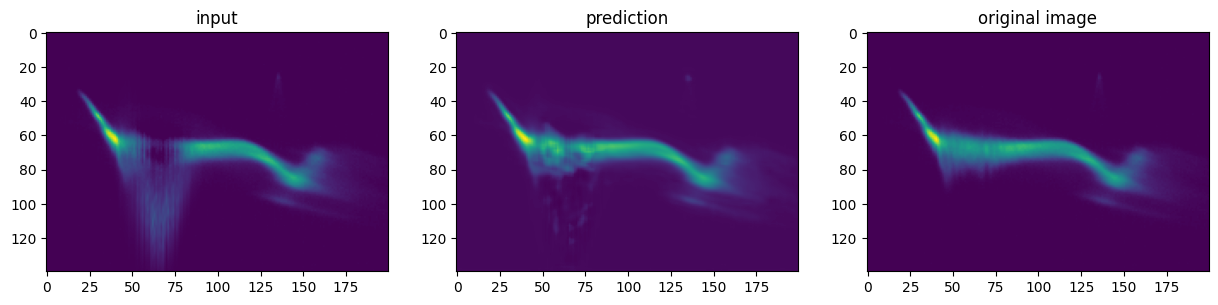

In [17]:
idx = 2
valX = val_inp[3][idx]
valRef = val_ref[3][idx].to(device)
valX = valX.to(device)
valY = val_out[3][idx]

model.eval()
with torch.no_grad():
    val_pred = model(valX.unsqueeze(0), valRef.unsqueeze(0))
    
valX = valX.squeeze().cpu()
valY = valY.squeeze().cpu()
val_pred = val_pred.squeeze().cpu()

fig, ax = plt.subplots(1,3, figsize=(15,8))
ax[0].imshow(valX)
ax[0].set_title("input")
ax[1].imshow(val_pred)
ax[1].set_title("prediction")
ax[2].imshow(valY)
ax[2].set_title("original image")

In [18]:
filepath = '/asap3/flash/gpfs/fl21/2024/data/11019435/raw/hdf/online-0/fl2user2'
filestr = glob.glob(filepath+f'/*run{50630}*20240125*')[0]

with h5py.File(filestr,'r') as fi:
        img_in = np.array(fi['/zraw/FLASH.DIAG/CAMERA/OTR9FL2XTDS/dGroup/value'][1])

In [19]:
filepath = '/asap3/flash/gpfs/fl21/2024/data/11019435/raw/hdf/online-0/fl2user2'
filestr = glob.glob(filepath+f'/*run{50631}*20240125*')[0]

with h5py.File(filestr,'r') as fi:
        img_ref = np.array(fi['/zraw/FLASH.DIAG/CAMERA/OTR9FL2XTDS/dGroup/value'][1])

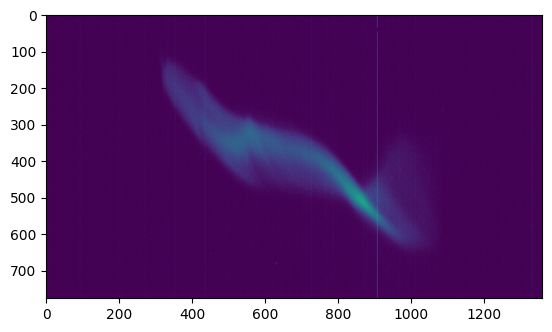

In [20]:
plt.imshow(img_ref)

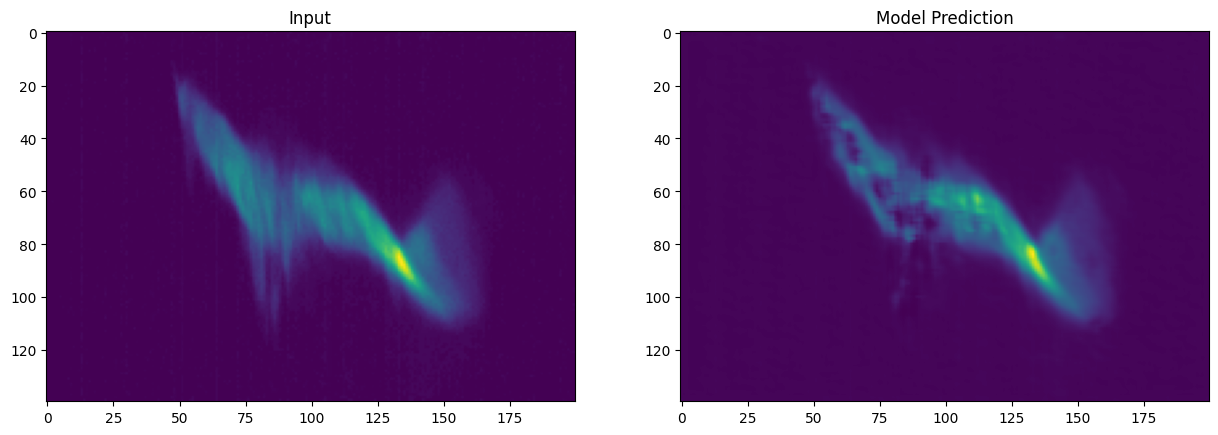

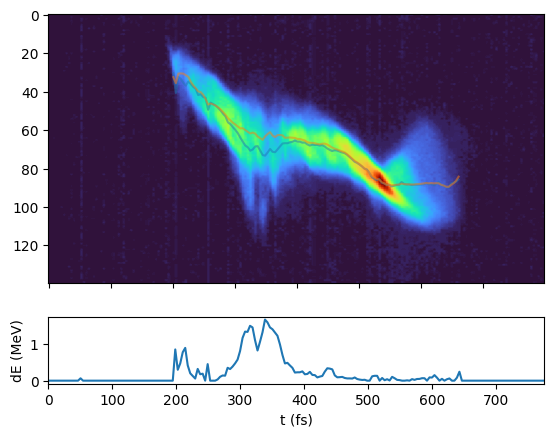

In [21]:
dE = 776 * 0.030 / 140  # MeV/pixel
dT = 1360 * 0.57 / 200  # fs/pixel

pred_in, pred_out = model_pred(model, img_in, img_ref, plot=True)
power_px = plot_power_profile(pred_in, pred_out, dE, dT)

In [22]:
filepath = '/asap3/flash/gpfs/fl21/2023/data/11016859/raw/hdf/express-3/fl2user2'
filestr = glob.glob(filepath+f'/*run{44525}*20230302*')[0]

with h5py.File(filestr,'r') as fi:
        img_in = np.array(fi['/zraw/FLASH.DIAG/CAMERA/OTR9FL2XTDS/dGroup/value'][2][600:1200,200:1800])
        
filepath = '/asap3/flash/gpfs/fl21/2023/data/11016859/raw/hdf/express-3/fl2user2'
filestr = glob.glob(filepath+f'/*run{44525}*20230302*')[18]

with h5py.File(filestr,'r') as fi:
        img_ref = np.array(fi['/zraw/FLASH.DIAG/CAMERA/OTR9FL2XTDS/dGroup/value'][1][600:1200,200:1800])
    

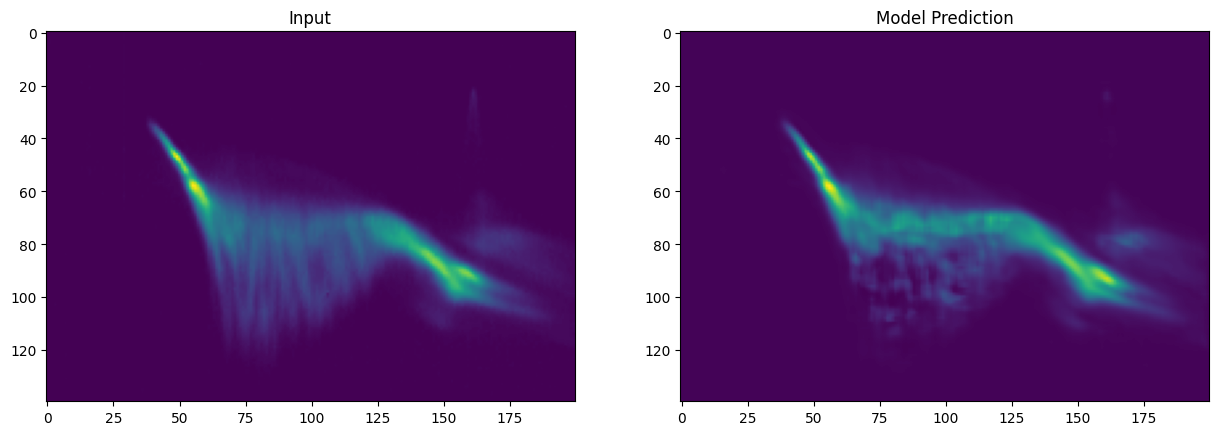

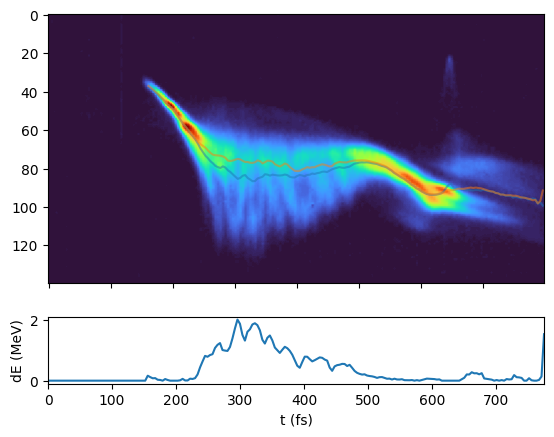

In [23]:
dE = 776 * 0.035 / 140  # MeV/pixel
dT = 1360 * 0.57 / 200  # fs/pixel

pred_in, pred_out = model_pred(model, img_in, img_ref, plot=True)
power_px = plot_power_profile(pred_in, pred_out, dE, dT)